GNN for Quark/Gluon classification

80% of the data is used for training.

10% is used for validation.

10% is used for testing .


In [2]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import energyflow
from sklearn.model_selection import train_test_split

X, y = energyflow.qg_jets.load(num_data=100000, pad=True, ncol=4, generator='pythia',
                               with_bc=False, cache_dir='~/.energyflow')

X = np.array(X)
y = np.array(y)

def preprocess_jets(X, pca_components=5):
    # Remove zero-padding (keep only real particles)
    mask = ~np.all(X == 0, axis=2)
    X_processed = [jet[mask[i]] for i, jet in enumerate(X)]

    pdgid_values = np.unique(np.concatenate([jet[:, 3] for jet in X_processed]))
    pdgid_values = pdgid_values[pdgid_values != 0]

    one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    flattened_pdgid = np.concatenate([jet[:, 3].reshape(-1, 1) for jet in X_processed])
    one_hot_encoder.fit(flattened_pdgid)

    # Standardization
    scaler = StandardScaler()
    flattened_data = np.vstack([jet[:, :3] for jet in X_processed])
    scaler.fit(flattened_data)

    for i in range(len(X_processed)):
        X_processed[i][:, :3] = scaler.transform(X_processed[i][:, :3])

    # Convert azimuthal angle phi to sin/cos
    for i in range(len(X_processed)):
        phi = X_processed[i][:, 2]
        X_processed[i] = np.hstack((X_processed[i], np.sin(phi)[:, None], np.cos(phi)[:, None]))
        X_processed[i] = np.delete(X_processed[i], 2, axis=1)

    for i in range(len(X_processed)):
        pdgid_onehot = one_hot_encoder.transform(X_processed[i][:, 3].reshape(-1, 1))
        X_processed[i] = np.hstack((X_processed[i], pdgid_onehot))
        X_processed[i] = np.delete(X_processed[i], 3, axis=1)

    pca = PCA(n_components=pca_components)
    flattened_pdgid = np.vstack([jet[:, -pdgid_onehot.shape[1]:] for jet in X_processed])
    pca.fit(flattened_pdgid)

    for i in range(len(X_processed)):
        pdgid_pca = pca.transform(X_processed[i][:, -pdgid_onehot.shape[1]:])
        X_processed[i] = np.hstack((X_processed[i][:, :-pdgid_onehot.shape[1]], pdgid_pca))

    return X_processed

X_preprocessed = preprocess_jets(X)

X = [torch.tensor(jet, dtype=torch.float) for jet in X_preprocessed]
y = torch.tensor(y, dtype=torch.long)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Preprocessing done! Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:642: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Preprocessing done! Train size: 80000, Validation size: 10000, Test size: 10000


## **Graph Construction Considerations for Jet Classification**

### **1. Representation of Jets as Graphs**
Jets are collections of particles in a high-energy physics event. Instead of treating them as unordered point clouds, we represent each jet as a graph, where:
- Nodes represent individual particles within a jet.
- Edges define relationships between particles, capturing spatial and kinematic correlations.

### **2. Node Features**
Each particle has four raw features: \( p_T \) , rapidity, azimuthal angle, and pdgid. The following considerations were applied:
- Retain all numerical features to preserve particle-level kinematic information.
- Remove zero-padding to ensure only real particles are considered.

### **3. Edge Construction (Using k-NN)**
Since there is no explicit connectivity between particles in a jet, we define edges using k-nearest neighbors (k-NN):
- **Feature Space for k-NN**: We construct edges based on rapidity and **azimuthal angle**, as these define the jet's spatial structure in cylindrical coordinates.
- **Choosing \( k = 10 \)**: Each particle is connected to its 10 nearest neighbors.

In [3]:
import torch
import torch_cluster
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader, Dataset
from torch_geometric.nn import GCNConv, global_mean_pool, knn_graph
import numpy as np

class JetGraphDataset(Dataset):
    def __init__(self, X, y, k=10):
        super(JetGraphDataset, self).__init__()
        self.X = X
        self.y = y
        self.k = k

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        jet = self.X[idx]
        label = self.y[idx]

        jet = jet[~torch.all(jet == 0, dim=1)]

        x = jet

        edge_index = knn_graph(x[:, 1:3], k=self.k, loop=False)

        return Data(x=x, edge_index=edge_index, y=label)

train_dataset = JetGraphDataset(X_train, y_train)
val_dataset = JetGraphDataset(X_val, y_val)
test_dataset = JetGraphDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


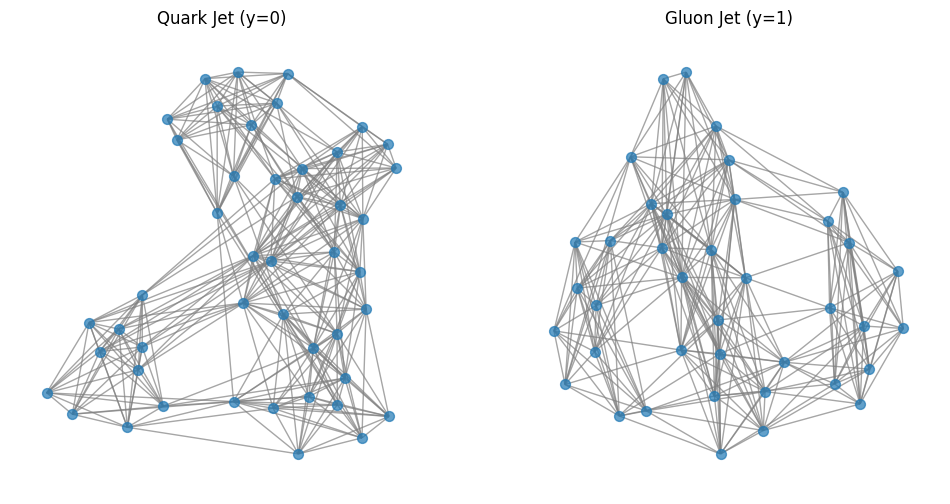

In [4]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

quark_idx = next(i for i, data in enumerate(val_dataset) if data.y.item() == 0)
gluon_idx = next(i for i, data in enumerate(val_dataset) if data.y.item() == 1)

quark_jet = train_dataset[quark_idx]
gluon_jet = train_dataset[gluon_idx]

G_quark = to_networkx(quark_jet, to_undirected=True)
G_gluon = to_networkx(gluon_jet, to_undirected=True)

seed = 42
pos_quark = nx.spring_layout(G_quark, seed=seed)
pos_gluon = nx.spring_layout(G_gluon, seed=seed)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
nx.draw(G_quark, pos=pos_quark, node_size=50, edge_color="gray", alpha=0.7, ax=ax)
ax.set_title("Quark Jet (y=0)")

ax = axes[1]
nx.draw(G_gluon, pos=pos_gluon, node_size=50, edge_color="gray", alpha=0.7, ax=ax)
ax.set_title("Gluon Jet (y=1)")

plt.show()


## Graph Convolutional Network (GCN)

### Model Architecture

1. **GCN Layer 1**  
   - Applies graph convolution to learn local relationships between particles.  
   - Uses Leaky ReLU activation to improve feature propagation.  
   - Applies batch normalization to stabilize training.  
   - Includes dropout to prevent overfitting.  

2. **GCN Layer 2**  
   - Extracts higher-level interactions between particles in the jet.  
   - Uses Leaky ReLU, batch normalization, and dropout, similar to the first layer.  

3. **Global Mean Pooling**  
   - Aggregates particle-level information to obtain a jet-level representation.  
   - Helps the model make predictions at the jet level rather than the particle level.  

4. **Fully ConnectedLayer**  
   - Maps the pooled jet representation to two output classes: quark or gluon jets.  
   - Uses softmax activation to compute class probabilities.


Epoch 1/50 | Train Loss: 0.6652, Train Acc: 0.6162 | Val Loss: 0.5759, Val Acc: 0.7514
Epoch 2/50 | Train Loss: 0.5919, Train Acc: 0.7310 | Val Loss: 0.5515, Val Acc: 0.7568
Epoch 3/50 | Train Loss: 0.5590, Train Acc: 0.7438 | Val Loss: 0.5268, Val Acc: 0.7625
Epoch 4/50 | Train Loss: 0.5449, Train Acc: 0.7501 | Val Loss: 0.5136, Val Acc: 0.7665
Epoch 5/50 | Train Loss: 0.5366, Train Acc: 0.7524 | Val Loss: 0.5115, Val Acc: 0.7644
Epoch 6/50 | Train Loss: 0.5316, Train Acc: 0.7527 | Val Loss: 0.5041, Val Acc: 0.7680
Epoch 7/50 | Train Loss: 0.5272, Train Acc: 0.7556 | Val Loss: 0.5004, Val Acc: 0.7717
Epoch 8/50 | Train Loss: 0.5248, Train Acc: 0.7561 | Val Loss: 0.4990, Val Acc: 0.7715
Epoch 9/50 | Train Loss: 0.5214, Train Acc: 0.7578 | Val Loss: 0.4978, Val Acc: 0.7716
Epoch 10/50 | Train Loss: 0.5201, Train Acc: 0.7583 | Val Loss: 0.4942, Val Acc: 0.7747
Epoch 11/50 | Train Loss: 0.5182, Train Acc: 0.7594 | Val Loss: 0.4948, Val Acc: 0.7734
Epoch 12/50 | Train Loss: 0.5176, Train A

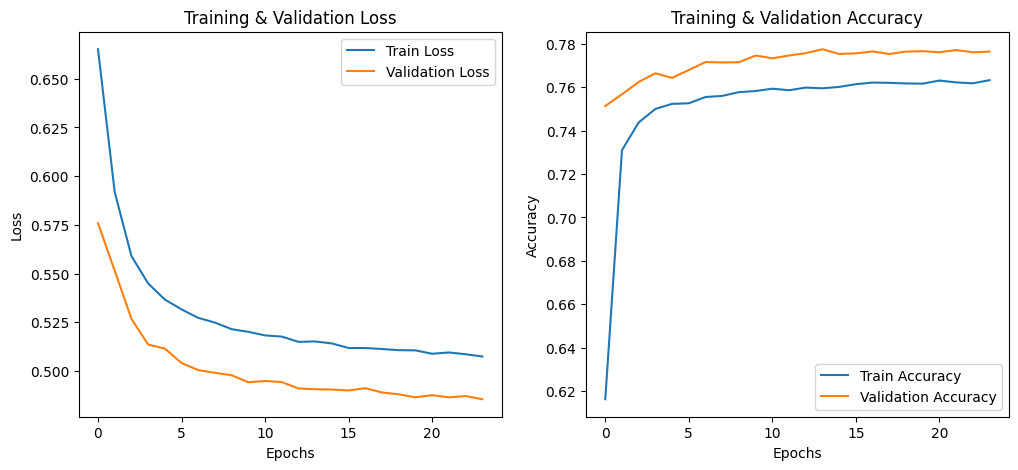

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool

class GCN(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, output_dim=2):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim)

        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim)

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.leaky_relu(self.conv1(x, edge_index))
        x = self.batchnorm1(x)
        x = self.dropout(x)

        x = F.leaky_relu(self.conv2(x, edge_index))
        x = self.batchnorm2(x)
        x = self.dropout(x)

        x = global_max_pool(x, data.batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


input_dim = X_train[0].shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=input_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

#training
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=50):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    early_stop_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (out.argmax(dim=1) == batch.y).sum().item()

        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_dataset)

        # Validation
        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch)
                loss = criterion(out, batch.y)
                val_loss += loss.item()
                correct += (out.argmax(dim=1) == batch.y).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / len(val_dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= 10:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses, train_accs, val_accs

train_losses, val_losses, train_accs, val_accs = train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=50)

#plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


In [6]:
def test(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            correct += (out.argmax(dim=1) == batch.y).sum().item()

    test_acc = correct / len(test_dataset)
    print(f"Test Accuracy: {test_acc:.4f}")
    return test_acc

# Evaluate on Test Set
gat_test_acc = test(model, test_loader)

Test Accuracy: 0.7676


## **Graph Attention Network (GAT)**
### **Model Architecture**
1. **GAT Layer 1**  
   - Applies **graph attention convolution** to dynamically learn particle relationships.  
   - Uses **multi-head attention (3 heads)** for enhanced feature representation.  
   - Applies **ELU activation** to improve feature propagation.  
   - Uses **Batch Normalization** and **Dropout (30%)** to prevent overfitting.

2. **GAT Layer 2**  
   - Further refines learned particle interactions with another **multi-head attention** layer.  
   - Uses **ELU activation**, **Batch Normalization**, and **Dropout** (same as Layer 1).  

3. **GAT Layer 3**  
   - Merges attention heads into a final feature representation.  
   - Uses a **single-head attention mechanism** to condense information.  
   - Applies **Batch Normalization** and **Dropout** for regularization.

4. **Global Mean Pooling**  
   - Aggregates per-particle features into a **jet-level representation**.  
   - Ensures the model makes predictions at the **jet level**.

5. **Fully Connected (FC) Layer**  
   - Maps the pooled features to **two output classes (quark or gluon jets)**.  
   - Uses **Softmax activation** to compute class probabilities.

Epoch 1/50 | Train Loss: 0.6321, Train Acc: 0.7025 | Val Loss: 0.5540, Val Acc: 0.7566
Epoch 2/50 | Train Loss: 0.5719, Train Acc: 0.7386 | Val Loss: 0.5463, Val Acc: 0.7579
Epoch 3/50 | Train Loss: 0.5573, Train Acc: 0.7416 | Val Loss: 0.5437, Val Acc: 0.7598
Epoch 4/50 | Train Loss: 0.5476, Train Acc: 0.7443 | Val Loss: 0.5391, Val Acc: 0.7595
Epoch 5/50 | Train Loss: 0.5437, Train Acc: 0.7454 | Val Loss: 0.5361, Val Acc: 0.7627
Epoch 6/50 | Train Loss: 0.5389, Train Acc: 0.7478 | Val Loss: 0.5337, Val Acc: 0.7618
Epoch 7/50 | Train Loss: 0.5352, Train Acc: 0.7481 | Val Loss: 0.5288, Val Acc: 0.7616
Epoch 8/50 | Train Loss: 0.5311, Train Acc: 0.7514 | Val Loss: 0.5279, Val Acc: 0.7638
Epoch 9/50 | Train Loss: 0.5278, Train Acc: 0.7518 | Val Loss: 0.5253, Val Acc: 0.7661
Epoch 10/50 | Train Loss: 0.5231, Train Acc: 0.7532 | Val Loss: 0.5237, Val Acc: 0.7701
Epoch 11/50 | Train Loss: 0.5191, Train Acc: 0.7558 | Val Loss: 0.5163, Val Acc: 0.7713
Epoch 12/50 | Train Loss: 0.5175, Train A

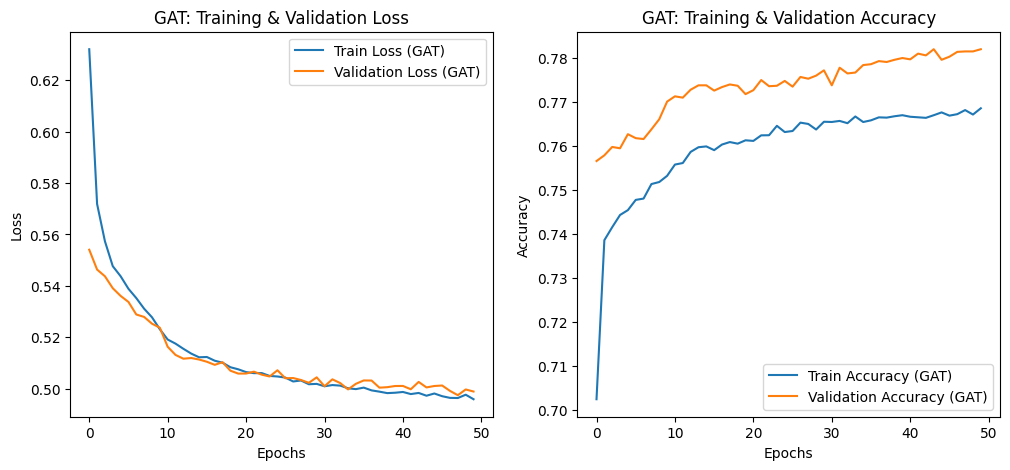

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_max_pool

class GAT(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=32, output_dim=2, heads=3):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim * heads)

        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, concat=True)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim * heads)

        self.conv3 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=False)
        self.batchnorm3 = nn.BatchNorm1d(hidden_dim)

        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.elu(self.conv1(x, edge_index))
        x = self.batchnorm1(x)
        x = self.dropout(x)

        x = F.elu(self.conv2(x, edge_index))
        x = self.batchnorm2(x)
        x = self.dropout(x)

        x = F.elu(self.conv3(x, edge_index))
        x = self.batchnorm3(x)
        x = self.dropout(x)

        x = global_max_pool(x, data.batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gat_model = GAT(input_dim=X_train[0].shape[1]).to(device)

optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.00001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

gat_train_losses, gat_val_losses, gat_train_accs, gat_val_accs = train_and_validate(
    gat_model, train_loader, val_loader, optimizer, criterion, epochs=50
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(gat_train_losses, label='Train Loss (GAT)')
plt.plot(gat_val_losses, label='Validation Loss (GAT)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GAT: Training & Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gat_train_accs, label='Train Accuracy (GAT)')
plt.plot(gat_val_accs, label='Validation Accuracy (GAT)')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("GAT: Training & Validation Accuracy")
plt.legend()

plt.show()



In [8]:
gat_test_acc = test(gat_model, test_loader)


Test Accuracy: 0.7712


## **Comparison of GCN and GAT Performance**

### **Observations:**
1. **Training & Validation Loss:**
   - Both **GCN** and **GAT** show a steady decrease in loss over epochs.
   - **GAT starts with a higher initial loss** but converges similarly to GCN.

2. **Training & Validation Accuracy:**
   - **GAT achieves higher test accuracy (77.12%)** compared to **GCN (76.76%)**.
   - **GAT maintains a higher gap** between training and validation accuracy, suggesting it captures more complex relationships.
   - **GCN follows a smoother convergence trend**, while **GAT exhibits more fluctuations**, likely due to attention mechanisms dynamically adjusting the graph structure.

### **Conclusion:**
- **GAT outperforms GCN** in classification accuracy, making it a better choice for distinguishing quark vs. gluon jets.
- However, **GAT is computationally more expensive** due to attention mechanisms, while **GCN is simpler and trains faster**.
- If **efficiency and interpretability** are important, GCN may be preferable.
- If **classification accuracy** is the primary goal, **GAT is the better choice**.
